In [ ]:
# Example from https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

In [2]:
# Building a simple financial model by getting data from the Pax API

# Financial Model Training
This guide uses machine learning to categorize a previous price pattern as volitile in the near future or not volitile. Getting a read on volatitliy can provide fund managers with valuable data

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.2.0
Eager execution: True


# A Volatility classification provlem
Imagine you see many price fluxuations accross a variety of securities. You would like to get a read on what the 24 volatility looks like. Depending on your theories about direction, knowing volatility might lead you to either invest more, or hedge. 

The Data we will look at has the following properties.
1. HighPrice
2. LowPrice
3. TimeIndex

We will preprocess the data to normalize it into returns, below.

# We Import the Pax development kit and look at some sample raw data 

In [2]:
import paxdk
 
import json
with open("../.config") as f:
    data = json.load(f)
api_key = data['api_key']    
 
pq = paxdk.PaxFinancialAPI(url_version='dev',api_key=api_key)    

PaxFinancialAPI v4 loaded!


In [6]:
import pandas as pd
import datetime

bars = pq.get_historical_hour({'api_key':api_key,
                                'time_in':datetime.datetime(2018,4,1,10),
                                'time_end':datetime.datetime(2019,4,1,12),
                                'Ticker':'BTCUSDT',
                                                             },remote=True)
#print(bars)
df=pd.DataFrame(bars)
display(df.head())

,ClosePrice,DateTime,HighPrice,LowPrice,OpenPrice,Ticker,_id,close,date_time,from_symbol,high,low,open,requested_date,time,to_symbol,volumefrom,volumeto
0,6699.95,2018-04-01 10:00:00,6758.89,6657.88,6757.17,BTCUSDT,None,6699.95,2018-04-01 10:00:00,BTC,6758.89,6657.88,6757.17,2020-03-22T18:47:40.640000,1522576800,USDT,2696.59,18068244.10
1,6691.29,2018-04-01 11:00:00,6706.96,6648.62,6705.50,BTCUSDT,None,6691.29,2018-04-01 11:00:00,BTC,6706.96,6648.62,6705.50,2020-03-22T18:47:40.640000,1522580400,USDT,2499.61,16697521.75
2,6687.22,2018-04-01 12:00:00,6730.72,6676.31,6690.27,BTCUSDT,None,6687.22,2018-04-01 12:00:00,BTC,6730.72,6676.31,6690.27,2020-03-22T18:47:40.640000,1522584000,USDT,2829.32,18958201.96
3,6554.28,2018-04-01 13:00:00,6689.66,6530.52,6689.45,BTCUSDT,None,6554.28,2018-04-01 13:00:00,BTC,6689.66,6530.52,6689.45,2020-03-22T18:47:40.640000,1522587600,USDT,4815.35,31727500.96
4,6509.23,2018-04-01 14:00:00,6554.28,6446.22,6554.28,BTCUSDT,None,6509.23,2018-04-01 14:00:00,BTC,6554.28,6446.22,6554.28,2020-03-22T18:47:40.640000,1522591200,USDT,5764.29,37440056.70


# Prepare Training Data CSV
Next, we would like to save this training data, locally, into a CSV file. In this tutorial we will try to use the past 10 hours, to forcast volitility in the next one hour. Thus, we would like to construct the following vector:


X_1 = < HighPrice_1/HighPrice_1 ... HighPriceN/HighPrice_1> 

X_2 = < LowPrice_1/LowPrice_1 ...  LowPrice_N/LowPrice_1 >

Y = < HighPrice_(N+1) - LowPrice_(N+1)>

Thus we have a feature given by


f = X_1 & X_2 & Y




In [7]:
features = []
count = 0
for index,row in df.iterrows():
    if count >= 13:
        i_0 = index - 13
        i_n = index -3
        i_n1 = index -2
        i_n3 = index
        
        x = df.loc[i_0:i_n]
        x1 = x['HighPrice']/x['HighPrice'].iloc[0]
        x2 = x['LowPrice']/x['LowPrice'].iloc[0]
        
        y = df.loc[i_n1:i_n3]
        high =y['HighPrice'].max()
        low = y['LowPrice'].min()
        yVal = (high-low)/low
        
        f =x1.to_list() + x2.to_list() +[yVal]
        features.append(f)
    count = count + 1
column_names = []
for i in range(0,11):
    column_names.append('HighPrice_'+str(i))
for i in range(0,11):
    column_names.append('LowPrice_'+str(i))
column_names.append('vol')

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))
train = pd.DataFrame(features, columns = column_names)  
train.to_csv('financialFeaturesTrain.csv', index=False)

Features: ['HighPrice_0', 'HighPrice_1', 'HighPrice_2', 'HighPrice_3', 'HighPrice_4', 'HighPrice_5', 'HighPrice_6', 'HighPrice_7', 'HighPrice_8', 'HighPrice_9', 'HighPrice_10', 'LowPrice_0', 'LowPrice_1', 'LowPrice_2', 'LowPrice_3', 'LowPrice_4', 'LowPrice_5', 'LowPrice_6', 'LowPrice_7', 'LowPrice_8', 'LowPrice_9', 'LowPrice_10']
Label: vol


# With Training data prepared, we can now consider our model. 
It should support 20 inputs and one output

In [8]:
train.head()

,HighPrice_0,HighPrice_1,HighPrice_2,HighPrice_3,HighPrice_4,HighPrice_5,HighPrice_6,HighPrice_7,HighPrice_8,HighPrice_9,...,LowPrice_2,LowPrice_3,LowPrice_4,LowPrice_5,LowPrice_6,LowPrice_7,LowPrice_8,LowPrice_9,LowPrice_10,vol
0,1.0,0.992317,0.995832,0.989757,0.969727,0.967749,1.014300,1.015116,1.014511,1.029213,...,1.002768,0.980871,0.968209,0.969008,0.967476,1.016109,1.013139,1.021687,1.029242,0.023037
1,1.0,1.003543,0.997421,0.977236,0.975242,1.022153,1.022976,1.022366,1.037182,1.035351,...,0.982237,0.969558,0.970358,0.968824,1.017524,1.014550,1.023110,1.030676,1.022892,0.038571
2,1.0,0.993900,0.973786,0.971799,1.018545,1.019365,1.018757,1.033521,1.031696,1.026278,...,0.965536,0.966333,0.964805,1.013304,1.010343,1.018867,1.026401,1.018650,1.011343,0.035903
3,1.0,0.979763,0.977764,1.024796,1.025622,1.025010,1.039865,1.038029,1.032577,1.022608,...,0.987906,0.986344,1.035925,1.032898,1.041612,1.049315,1.041390,1.033921,1.036584,0.035653
4,1.0,0.997960,1.045964,1.046806,1.046182,1.061343,1.059470,1.053905,1.043730,1.041664,...,0.999243,1.049472,1.046405,1.055234,1.063037,1.055009,1.047442,1.050139,1.050392,0.015825


In [9]:
print(train['vol'].min())
print(train['vol'].max())
print(train['vol'].mean())
print(train['vol'].median())


0.0010366668925870712
0.18285231786728265
0.0136237851168539
0.009894610333574912


# We can plot the dimensions
Below we plot three of the dimensions, looking for any coorelation with the y Axis

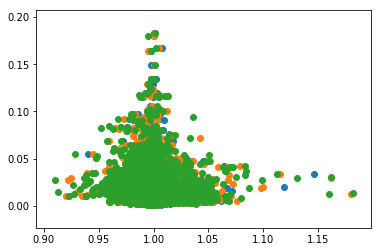

In [10]:
plt.scatter(train['HighPrice_1'],
            train['vol'])
plt.scatter(train['HighPrice_2'],
            train['vol'])
plt.scatter(train['HighPrice_3'],
            train['vol'])


# Prepare the dataframe for training
Next, we prepare the dataset for training. We opt to load data from a csv file.

In [11]:
financialFeatures = open("financialFeaturesTrain.csv")
batch_size = 1000
print(column_names)
print(label_name)
train_dataset = tf.data.experimental.make_csv_dataset(
    file_pattern='financialFeaturesTrain.csv',
    batch_size=batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

['HighPrice_0', 'HighPrice_1', 'HighPrice_2', 'HighPrice_3', 'HighPrice_4', 'HighPrice_5', 'HighPrice_6', 'HighPrice_7', 'HighPrice_8', 'HighPrice_9', 'HighPrice_10', 'LowPrice_0', 'LowPrice_1', 'LowPrice_2', 'LowPrice_3', 'LowPrice_4', 'LowPrice_5', 'LowPrice_6', 'LowPrice_7', 'LowPrice_8', 'LowPrice_9', 'LowPrice_10', 'vol']
vol


In [12]:
features, labels = next(iter(train_dataset))

#print(features)

In [13]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [14]:
train_dataset = train_dataset.map(pack_features_vector)

In [15]:
features, labels = next(iter(train_dataset))

print(len(features))
print(len(labels))

lbl2 = tf.reshape(labels,[len(labels),1])

print(tf.shape(labels))
print(tf.shape(lbl2))



1000
1000
tf.Tensor([1000], shape=(1,), dtype=int32)
tf.Tensor([1000    1], shape=(2,), dtype=int32)


# Train a model with the data

In [16]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(22,)),  # input shape required
  tf.keras.layers.Dense(15, activation=tf.nn.relu),
  tf.keras.layers.Dense(5, activation=tf.nn.relu),
  tf.keras.layers.Dense(8, activation=tf.nn.relu),
  tf.keras.layers.Dense(3, activation=tf.nn.relu),
  tf.keras.layers.Dense(1)
])

In [17]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.038569  ],
       [0.03765087],
       [0.03920037],
       [0.0385066 ],
       [0.03959331]], dtype=float32)>

In [18]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [20]:
print(predictions[0])
print("Prediction: {}".format(predictions))
#print("    Labels: {}".format(labels))

tf.Tensor([0.038569], shape=(1,), dtype=float32)
Prediction: [[0.038569  ]
 [0.03765087]
 [0.03920037]
 [0.0385066 ]
 [0.03959331]
 [0.04424696]
 [0.04123408]
 [0.04195625]
 [0.03962528]
 [0.04321341]
 [0.04165633]
 [0.03775265]
 [0.03831117]
 [0.04033074]
 [0.03892118]
 [0.03953713]
 [0.03558092]
 [0.03963558]
 [0.0361141 ]
 [0.04892692]
 [0.04214603]
 [0.0469989 ]
 [0.03947001]
 [0.0388777 ]
 [0.03530068]
 [0.03884779]
 [0.03827623]
 [0.03836274]
 [0.03905858]
 [0.03698761]
 [0.0396426 ]
 [0.04141189]
 [0.03909231]
 [0.0380435 ]
 [0.03940591]
 [0.03881129]
 [0.03868918]
 [0.03797795]
 [0.03572955]
 [0.04333398]
 [0.03937116]
 [0.03804032]
 [0.04536039]
 [0.03820644]
 [0.03694482]
 [0.03813341]
 [0.03871745]
 [0.03868522]
 [0.03872392]
 [0.03845417]
 [0.03719767]
 [0.03874841]
 [0.03917631]
 [0.03520682]
 [0.04398126]
 [0.03741507]
 [0.03722136]
 [0.03878302]
 [0.0391434 ]
 [0.04002091]
 [0.03853732]
 [0.03747148]
 [0.03982392]
 [0.04113126]
 [0.03820557]
 [0.04100798]
 [0.03797901]
 

In [21]:
loss_object = tf.keras.losses.MeanSquaredError()

In [36]:
import numpy as np
def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    #y = tf.transpose(y, perm=[1, 0])
    #print(y)
    #print(y_)
    return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, lbl2, training=False)
print("Loss test: {}".format(l))

InvalidArgumentError: In[0] is not a matrix. Instead it has shape [] [Op:MatMul]

In [23]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [275]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 0.1749269962310791
Step: 1,         Loss: 0.0028016772121191025


In [25]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 501

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        ####epoch_accuracy.update_state(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03f}: Loss: {:.10f}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                ####epoch_accuracy.result()
                                                                   
                                                                   ))

Epoch 0.000000: Loss: 0.0003752182
Epoch 50.000000: Loss: 0.0001864900
Epoch 100.000000: Loss: 0.0001854708
Epoch 150.000000: Loss: 0.0001855136
Epoch 200.000000: Loss: 0.0001851735
Epoch 250.000000: Loss: 0.0001844697
Epoch 300.000000: Loss: 0.0001803706
Epoch 350.000000: Loss: 0.0001780304
Epoch 400.000000: Loss: 0.0001786709
Epoch 450.000000: Loss: 0.0001779382
Epoch 500.000000: Loss: 0.0001792088


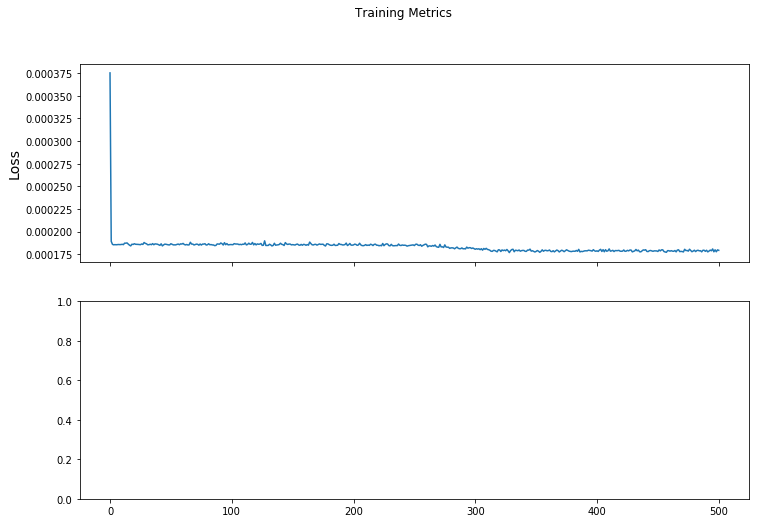

In [26]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

plt.show()

# Testing a trained model
After training the model, it is now possible to test for accuracy

In [27]:
import pandas as pd
import datetime

bars = pq.get_historical_hour({'api_key':api_key,
                                'time_in':datetime.datetime(2019,4,1,10),
                                'time_end':datetime.datetime(2020,4,1,12),
                                'Ticker':'BTCUSDT',
                                                             },remote=True)
#print(bars)
df=pd.DataFrame(bars)
display(df.head())

,ClosePrice,DateTime,HighPrice,LowPrice,OpenPrice,Ticker,_id,close,date_time,from_symbol,high,low,open,requested_date,time,to_symbol,volumefrom,volumeto
0,4127.28,2019-04-01 10:00:00,4134.78,4125.60,4134.05,BTCUSDT,None,4127.28,2019-04-01 10:00:00,BTC,4134.78,4125.60,4134.05,2020-03-24T00:19:08.018000,1554112800,USDT,11593.32,47880008.75
1,4128.35,2019-04-01 11:00:00,4133.07,4124.78,4127.28,BTCUSDT,None,4128.35,2019-04-01 11:00:00,BTC,4133.07,4124.78,4127.28,2020-03-24T00:19:08.018000,1554116400,USDT,11293.09,46625321.93
2,4139.40,2019-04-01 12:00:00,4141.82,4128.07,4128.35,BTCUSDT,None,4139.40,2019-04-01 12:00:00,BTC,4141.82,4128.07,4128.35,2020-03-24T00:19:08.018000,1554120000,USDT,12660.76,52370436.71
3,4148.42,2019-04-01 13:00:00,4148.45,4135.39,4139.40,BTCUSDT,None,4148.42,2019-04-01 13:00:00,BTC,4148.45,4135.39,4139.40,2020-03-24T00:19:08.018000,1554123600,USDT,12767.36,52862690.51
4,4139.55,2019-04-01 14:00:00,4156.41,4138.65,4148.42,BTCUSDT,None,4139.55,2019-04-01 14:00:00,BTC,4156.41,4138.65,4148.42,2020-03-24T00:19:08.018000,1554127200,USDT,17339.14,71925840.64


In [28]:
features = []
count = 0
for index,row in df.iterrows():
    if count >= 13:
        i_0 = index - 13
        i_n = index -3
        i_n1 = index -2
        i_n3 = index
        
        x = df.loc[i_0:i_n]
        x1 = x['HighPrice']/x['HighPrice'].iloc[0]
        x2 = x['LowPrice']/x['LowPrice'].iloc[0]
        
        y = df.loc[i_n1:i_n3]
        high =y['HighPrice'].max()
        low = y['LowPrice'].min()
        yVal = (high-low)/low
        
        f =x1.to_list() + x2.to_list() +[yVal]
        features.append(f)
    count = count + 1
column_names = []
for i in range(0,11):
    column_names.append('HighPrice_'+str(i))
for i in range(0,11):
    column_names.append('LowPrice_'+str(i))
column_names.append('vol')

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))
train = pd.DataFrame(features, columns = column_names)  
train.to_csv('financialFeaturesTest.csv', index=False)

Features: ['HighPrice_0', 'HighPrice_1', 'HighPrice_2', 'HighPrice_3', 'HighPrice_4', 'HighPrice_5', 'HighPrice_6', 'HighPrice_7', 'HighPrice_8', 'HighPrice_9', 'HighPrice_10', 'LowPrice_0', 'LowPrice_1', 'LowPrice_2', 'LowPrice_3', 'LowPrice_4', 'LowPrice_5', 'LowPrice_6', 'LowPrice_7', 'LowPrice_8', 'LowPrice_9', 'LowPrice_10']
Label: vol


In [29]:
financialFeatures = open("financialFeaturesTest.csv")
batch_size = 1000
print(column_names)
print(label_name)
test_dataset = tf.data.experimental.make_csv_dataset(
    file_pattern='financialFeaturesTest.csv',
    batch_size=batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)


['HighPrice_0', 'HighPrice_1', 'HighPrice_2', 'HighPrice_3', 'HighPrice_4', 'HighPrice_5', 'HighPrice_6', 'HighPrice_7', 'HighPrice_8', 'HighPrice_9', 'HighPrice_10', 'LowPrice_0', 'LowPrice_1', 'LowPrice_2', 'LowPrice_3', 'LowPrice_4', 'LowPrice_5', 'LowPrice_6', 'LowPrice_7', 'LowPrice_8', 'LowPrice_9', 'LowPrice_10', 'vol']
vol


In [30]:
test_dataset = test_dataset.map(pack_features_vector)

In [31]:
test_accuracy = tf.keras.metrics.MeanSquaredError()
#chance_accuracy = tf.keras.metrics.MeanSquaredError()

for (x, y) in test_dataset:
    # training=False is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model(x, training=False)
    #print(logits[0])
    #print(logits[0])
    #prediction = tf.argmax(logits, axis=1)#, output_type=tf.float32)
    #print(prediction[0])
    prediction = logits
    test_accuracy(prediction, y)
    #chancelogits = chancemodel(x, training=False)
    #chanceprediction = tf.argmax(chancelogits, axis=1, output_type=tf.int32)
    #chance_accuracy(chanceprediction, y)

print("Trained Test set accuracy: {:.10%}".format(test_accuracy.result()))
#print("Chance Test set accuracy: {:.10%}".format(chance_accuracy.result()))

Trained Test set accuracy: 0.0363632978%


# Plot Historical data, seeing how the model performs

In [32]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
bars = pq.get_historical_hour({'api_key':api_key,
                                'time_in':datetime.datetime(2019,4,1,10),
                                'time_end':datetime.datetime(2020,4,1,12),
                                'Ticker':'BTCUSDT',
                                                             },remote=True)
#print(bars)
df = pd.DataFrame(bars)

In [33]:

highList = []
lowList = []
volList = []
dateList = []
predictVol = []
df=pd.DataFrame(bars)
validateFeatures = []
count = 0
for index,row in df.iterrows():
    if count >= 13:
        i_0 = index - 13
        i_n = index -3
        i_n1 = index -2
        i_n3 = index
        
        x = df.loc[i_0:i_n]
        x1 = x['HighPrice']/x['HighPrice'].iloc[0]
        x2 = x['LowPrice']/x['LowPrice'].iloc[0]
        
        y = df.loc[i_n1:i_n3]
        high =y['HighPrice'].max()
        low = y['LowPrice'].min()
        yVal = (high-low)/low
        
        highList.append(x1.iloc[10]-1)
        lowList.append(x2.iloc[10]-1)
        volList.append(yVal)
        dateList.append(row['DateTime'])
        f =x1.to_list() + x2.to_list() +[yVal]
        validateFeatures.append(f)
        
        
        ten = tf.convert_to_tensor(x1.to_list() + x2.to_list())
        ten = tf.reshape(ten,[1,len(ten)])

        logits = model(ten, training=False)
        #print(float(logits[0][0]))
        prediction = float(logits[0][0])#, output_type=tf.float32)
        predictVol.append(prediction)
        
    count = count + 1
#print(predictVol)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


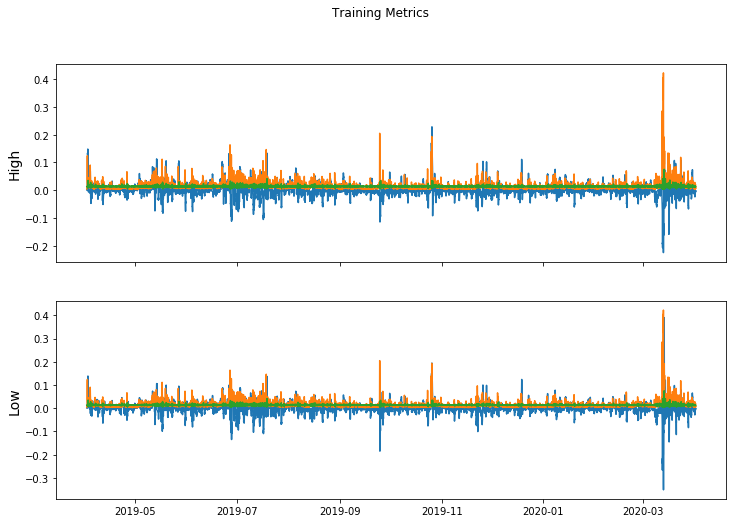

In [34]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("High", fontsize=14)
axes[0].plot(dateList,highList)
axes[0].plot(dateList,volList)
axes[0].plot(dateList,predictVol)


axes[1].set_ylabel("Low", fontsize=14)
axes[1].plot(dateList,lowList)
axes[1].plot(dateList,volList)
axes[1].plot(dateList,predictVol)

plt.show()


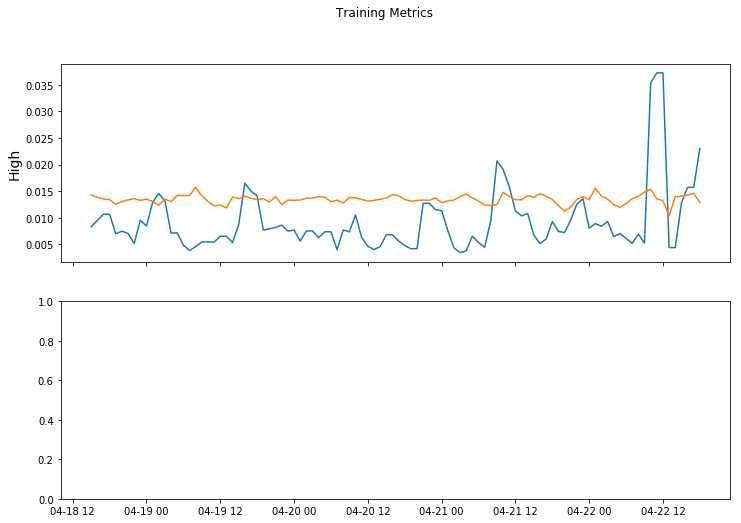

In [35]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("High", fontsize=14)
axes[0].plot(dateList[400:500],volList[400:500])
axes[0].plot(dateList[400:500],predictVol[400:500])


plt.show()
